## Group 18 NIAs
#### 100496527
#### 100496468
#### 100496459

# Problem Statement

We have data from a set of power plants that distribute energy to several regions over a time period of 3 days. Each plant has a fixed operating cost, a variable cost per MW(megawatt) of energy generated, a daily maximum production capacity, and we also have data related to their emission limits, that is important to note that not all of them have, as some of these plants make renewable energy, but this consideration will be taken into account in part d. Additionally, ensuring that at least 45% of the total energy comes from renewable sources.

The goal of our Power Plant Problem is to minimize the cost of energy providing some mimimum requirements of energy production for each given region. This problem can be formulated as a linear model, where constraints limit the maximum capacity of each given plant, the daily energy demand in each region and the minimum production required. 

Our Power Plants Production problem can be formulated mathematically as a linear programming problem using the following model.

## Sets

 $P$ = set of power plants (A, B, C, D, E)  
 $R$ = set of regions (1, 2, 3)  
 $D$ = set of days (1, 2, 3)


## Parameters

 $cm_i$ = cost per MW(MegaWatt) for plant $i$, $\forall i \in P$  
 $c_i$ = fixed cost for plant $i$, $\forall i \in P$  
 $cap_i$ = maximum capacity of plant $i$, $\forall i \in P$  
 $d_{jt}$ = power demand for region $j$ in day $t$, $\forall j \in R, \forall t \in D$  
 $e_i$ = emissions of plant $i$, $\forall i \in P$   
 $er_i$ = emission rate of plant $i$, $\forall i \in P$ 

Values of the given parameters related to i(Plants), except the ones related with emisions that are presented in d:
 Params   | $i=A$ | $i=B$ | $i=C$ | $i=D$ | $i=E$
 ---------|-------|-------|-------|-------|----------
  $cm_i$  | 20    | 22    | 18    | 30    | 28
  $c_i$   | 3000  | 3500  | 4000  | 5000  | 4500
  $cap_i$ | 100   | 120   | 150   | 200   | 250 

Values of the demand parameter, related to j(Regions) and t(Days):
 $d_{jt}$ | $t=1$ | $t=2$ | $t=3$
 ---------|-------|-------|-----------
  $j=1$   | 100   | 110   | 115 
  $j=2$   | 150   | 140   | 160 
  $j=3$   | 130   | 120   | 135

## Decision Variable
 $x_{ijt}$ = power generated by plant i for region j on day t   


## Objective Function

Minimize the total cost of energy production:

\begin{align*}
\underset{x_{ijt}}{\min} & \quad \sum_{i \in P} \left(\text{c}_i + \sum_{j \in R} \sum_{t \in D} \text{cm}_i \cdot x_{i,j,t} \right)\\
\end{align*} 
 

## Constraints
### Capacity constraint
Maximum capacity of plant $i \in P$ on day $t \in D$:  

\begin{align*}
\sum_{j \in R} x_{i,j,t} \leq \text{cap}_i \quad \forall i \in P, \, \forall t \in D
\end{align*} 

### Demand constraint
Demand constraint for region $j \in R$ on day $t \in D$:  

\begin{align*}
\sum_{i \in P} x_{i,j,t} \geq \text{d}_{jt} \quad \forall j \in R, \, \forall t \in D
\end{align*} 


### Minimum production constraint
Minimum production of plant $i \in P$ on day $t \in D$:

\begin{align*}
\sum_{j \in R} x_{i,j,t} \geq 10 \quad \forall i \in P, \, \forall t \in D
\end{align*}

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import numpy

In [2]:
# Create a model
model = ConcreteModel()


# Defining sets
model.plants = Set(initialize=['A', 'B', 'C', 'D', 'E'], doc="Set of plants")
model.regions = Set(initialize=[1, 2, 3], doc="Set of regions")
model.days = Set(initialize=[1, 2, 3], doc="Set of days")


# Defining parameters
model.cost_per_mw = Param(model.plants, initialize={'A': 20, 'B': 22, 'C': 18, 'D': 30, 'E': 28}, doc="Cost per MW")

model.fixed_cost = Param(model.plants, initialize={'A': 3000, 'B': 3500, 'C': 4000, 'D': 5000, 'E': 4500}, doc="Fixed cost")

model.max_capacity = Param(model.plants, initialize={'A': 100, 'B': 120, 'C': 150, 'D': 200, 'E': 250}, doc="Max capacity")

model.demand = Param(model.regions, model.days, initialize={(1, 1): 100, (1, 2): 110, (1, 3): 115,
                                                             (2, 1): 150, (2, 2): 140, (2, 3): 160,
                                                             (3, 1): 130, (3, 2): 120, (3, 3): 135},
                                                             doc="Demand")


# Defining variables
model.x = Var(model.plants, model.regions, model.days, within=NonNegativeReals)


# Defining objective function
def objective_rule(model):
    return sum(model.cost_per_mw[i] * model.x[i,j,t] for i in model.plants for j in model.regions for t in model.days) + \
           sum(model.fixed_cost[i] for i in model.plants)

model.objective = Objective(rule=objective_rule, sense=minimize, doc="Objective function")


# Defining constraints
# Capacity constraint
def capacity_rule(model, i, t):
    return sum(model.x[i,j,t] for j in model.regions) <= model.max_capacity[i]

model.capacity_constraint = Constraint(model.plants, model.days, rule=capacity_rule, doc="Capacity constraint")

# Demand constraint
def demand_rule(model, j, t):
    return sum(model.x[i,j,t] for i in model.plants) >= model.demand[j,t]

model.demand_constraint = Constraint(model.regions, model.days, rule=demand_rule, doc="Demand constraint")

# Minimum production constraint
def min_production_rule(model, i, t):
    return sum(model.x[i,j,t] for j in model.regions) >= 10

model.min_production_constraint = Constraint(model.plants, model.days, rule=min_production_rule, doc="Minimum production constraint")

In [3]:
# Model solution
model.dual = Suffix(direction=Suffix.IMPORT)

# Solve the model
solver = SolverFactory('glpk')
solver.solve(model)

for i in model.plants:
    print(f"Results por plant {i}:")
    for t in model.days:
        for j in model.regions:
            print(f"  Day {t}, Region {j}: {model.x[i,j,t].value} MW")

Results por plant A:
  Day 1, Region 1: 0.0 MW
  Day 1, Region 2: 100.0 MW
  Day 1, Region 3: 0.0 MW
  Day 2, Region 1: 0.0 MW
  Day 2, Region 2: 100.0 MW
  Day 2, Region 3: 0.0 MW
  Day 3, Region 1: 75.0 MW
  Day 3, Region 2: 0.0 MW
  Day 3, Region 3: 25.0 MW
Results por plant B:
  Day 1, Region 1: 0.0 MW
  Day 1, Region 2: 50.0 MW
  Day 1, Region 3: 60.0 MW
  Day 2, Region 1: 0.0 MW
  Day 2, Region 2: 40.0 MW
  Day 2, Region 3: 60.0 MW
  Day 3, Region 1: 0.0 MW
  Day 3, Region 2: 120.0 MW
  Day 3, Region 3: 0.0 MW
Results por plant C:
  Day 1, Region 1: 80.0 MW
  Day 1, Region 2: 0.0 MW
  Day 1, Region 3: 70.0 MW
  Day 2, Region 1: 90.0 MW
  Day 2, Region 2: 0.0 MW
  Day 2, Region 3: 60.0 MW
  Day 3, Region 1: 0.0 MW
  Day 3, Region 2: 40.0 MW
  Day 3, Region 3: 110.0 MW
Results por plant D:
  Day 1, Region 1: 10.0 MW
  Day 1, Region 2: 0.0 MW
  Day 1, Region 3: 0.0 MW
  Day 2, Region 1: 10.0 MW
  Day 2, Region 2: 0.0 MW
  Day 2, Region 3: 0.0 MW
  Day 3, Region 1: 10.0 MW
  Day 3, R

## Solution Interpretation

In [4]:
# Display sensitivities (Lagrange multipliers) for each constraint
print("Sensitivities (Lagrange Multipliers):")

# Demand constraints
print("\nLagrange multipliers for demand constraints:")
for index in model.demand_constraint:
    print(f"  Constraint {index}: {model.dual[model.demand_constraint[index]]}")

# Capacity constraints
print("\nLagrange multipliers for capacity constraints:")
for index in model.capacity_constraint:
    print(f"  Constraint {index}: {model.dual[model.capacity_constraint[index]]}")

# Minimum production constraints
print("\nLagrange multipliers for minimum production constraints:")
for index in model.min_production_constraint:
    print(f"  Constraint {index}: {model.dual[model.min_production_constraint[index]]}")

Sensitivities (Lagrange Multipliers):

Lagrange multipliers for demand constraints:
  Constraint (1, 1): 22.0
  Constraint (1, 2): 22.0
  Constraint (1, 3): 28.0
  Constraint (2, 1): 22.0
  Constraint (2, 2): 22.0
  Constraint (2, 3): 28.0
  Constraint (3, 1): 22.0
  Constraint (3, 2): 22.0
  Constraint (3, 3): 28.0

Lagrange multipliers for capacity constraints:
  Constraint ('A', 1): -2.0
  Constraint ('A', 2): -2.0
  Constraint ('A', 3): -8.0
  Constraint ('B', 1): 0.0
  Constraint ('B', 2): 0.0
  Constraint ('B', 3): -6.0
  Constraint ('C', 1): -4.0
  Constraint ('C', 2): -4.0
  Constraint ('C', 3): -10.0
  Constraint ('D', 1): 0.0
  Constraint ('D', 2): 0.0
  Constraint ('D', 3): 0.0
  Constraint ('E', 1): 0.0
  Constraint ('E', 2): 0.0
  Constraint ('E', 3): 0.0

Lagrange multipliers for minimum production constraints:
  Constraint ('A', 1): 0.0
  Constraint ('A', 2): 0.0
  Constraint ('A', 3): 0.0
  Constraint ('B', 1): 0.0
  Constraint ('B', 2): 0.0
  Constraint ('B', 3): 0.0
 

## Interpretation of the sensitivities

Lagrange Multipliers for Demand Constraints:
    -These values represent how much the objective function would change if the demand constraint for each region on each day were relaxed by one unit.
    -The multipliers are all positive, suggesting that increasing the demand in any of the regions (1, 2, or 3) by one unit will increase the total cost (or decrease the total benefit) by the corresponding multiplier value.
    -Values of 22.0 and 28.0 indicate the sensitivity of the system to demand changes across different days and regions. For example, an increase in demand for Region 3 on any day would increase the cost by 28 MW, which is higher than for Region 1 or Region 2, where it’s 22 MW.


Lagrange Multipliers for Capacity Constraints:
    -These values represent how much the objective function would change if the capacity of each plant was increased by one unit.
    -Negative values (e.g., -2.0, -4.0, -6.0) indicate that increasing the capacity of these plants would decrease the total objective (e.g., cost), suggesting that these plants have unused or unexploited capacity.
    -A value of 0.0 for plants D and E indicates that increasing their capacity would not change the objective, meaning these plants are not limiting the overall production and their full capacity is not being utilized.


Lagrange Multipliers for Minimum Production Constraints:
    -These values reflect the change in the objective function if the minimum production requirement for each plant is relaxed by one unit.
    -For plants D and E, positive values (e.g., 8.0, 6.0) suggest that relaxing the minimum production requirement would reduce the overall cost. This indicates that these plants are being constrained in their minimum production capacity.
    -The multipliers for other plants (A, B, C) are all 0.0, suggesting that their minimum production constraints are not actively influencing the solution. These plants are either already producing above their minimum threshold or the constraints are not binding.

### Some more plots

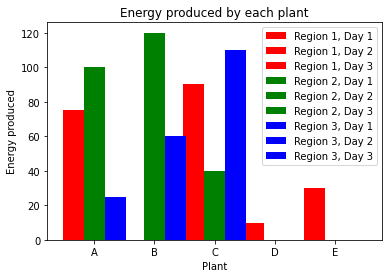

In [5]:
#Energy produced by each plant
fig, ax = plt.subplots()
width = 0.35
ind = numpy.arange(len(model.plants))
colors = ['r', 'g', 'b', 'y', 'm']
bars = []
for j in model.regions:
    for t in model.days:
        bars.append(ax.bar(ind + (j-1)*width, [model.x[i,j,t].value for i in model.plants], width, color=colors[j-1], label=f'Region {j}, Day {t}'))
ax.set_xticks(ind + width)
ax.set_xticklabels(model.plants)
ax.set_xlabel('Plant')
ax.set_ylabel('Energy produced')
ax.set_title('Energy produced by each plant')
ax.legend()
plt.show()

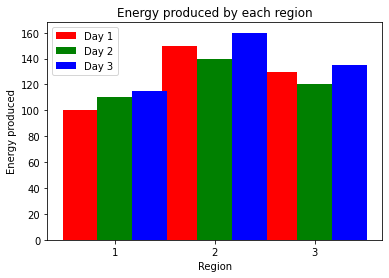

In [6]:
#Energy produced by each region
fig, ax = plt.subplots()
width = 0.35
ind = numpy.arange(len(model.regions))
colors = ['r', 'g', 'b']
bars = []
for i, t in enumerate(model.days):
    bars.append(ax.bar(ind + i*width, [sum(model.x[i,j,t].value for i in model.plants) for j in model.regions], width, color=colors[i], label=f'Day {t}'))
ax.set_xticks(ind + width)
ax.set_xticklabels(model.regions)
ax.set_xlabel('Region')
ax.set_ylabel('Energy produced')
ax.set_title('Energy produced by each region')
ax.legend()
plt.show()

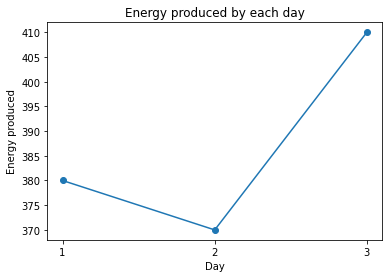

In [7]:
#Energy produced in each day
fig, ax = plt.subplots()
ind = numpy.arange(len(model.days))
ax.plot(ind, [sum(model.x[i,j,t].value for i in model.plants for j in model.regions) for t in model.days], marker='o')
ax.set_xticks(ind)
ax.set_xticklabels(model.days)
ax.set_xlabel('Day')
ax.set_ylabel('Energy produced')
ax.set_title('Energy produced by each day')
plt.show()

## Problem Statement reformulation.

Now we keep working on minimizing the the operational cost of five power plants while meeting regional electricity demand over three days. The main difference with part a is that the decision to operate each plant is modeled with a binary variable, where 1 means the plant is working and 0 means it is not. So the objective is still the same, mantaining capacity and demand constraint, modifying a bit the minimum production constraint, while adhering to some extra restrictions like they are the emision and renewable constraints (related to the pollution generated) and the mutual exclusion constraint (ensuring that at max one out of A or B is used).

Our Power Plants Production problem reformulated can be expressed mathematically using the following model.

## Sets

 The set of plants, regions and days is equal to the one used above:
 $P$ = set of power plants (A, B, C, D, E)  
 $R$ = set of regions (1, 2, 3)  
 $D$ = set of days (1, 2, 3)


## Parameters

 The parameters are the same as to the ones used above, adding the emissions and emission rate of plants D and E:
 $cm_i$ = cost per MW(MegaWatt) for plant $i$, $\forall i \in P$  
 $c_i$ = fixed cost for plant $i$, $\forall i \in P$  
 $cap_i$ = maximum capacity of plant $i$, $\forall i \in P$  
 $d_{jt}$ = power demand for region $j$ in day $t$, $\forall j \in R, \forall t \in D$  
 $e_i$ = emissions of plant $i$, $\forall i \in P$  
 $er_i$ = emission rate of plant $i$, $\forall i \in P$ 

Values of the given parameters related to i(Plants):
 Params   | $i=A$ | $i=B$ | $i=C$ | $i=D$ | $i=E$
 ---------|-------|-------|-------|-------|----------
  $cm_i$  | 20    | 22    | 18    | 30    | 28
  $c_i$   | 3000  | 3500  | 4000  | 5000  | 4500
  $cap_i$ | 100   | 120   | 150   | 200   | 250 
  $e_i$   | 0     | 0     | 0     | 90    | 100
  $er_i$  | 0     | 0     | 0     | 0.6   | 0.5       

Values of the demand parameter, related to j(Regions) and t(Days):
 $d_{jt}$ | $t=1$ | $t=2$ | $t=3$
 ---------|-------|-------|-----------
  $j=1$   | 100   | 110   | 115 
  $j=2$   | 150   | 140   | 160 
  $j=3$   | 130   | 120   | 135

## Decision Variable

 The decision variable x is kept equally as before, but now we add our new variable y:   
 $x_{ijt}$ = power generated by plant i for region j on day t   
 $$
 y_{it}=
 \left\{\begin{array}{ll} 
 1, & \text{if plant $i$ works on day $t$}\\
 0, & \text{if plant $i$ does not work on day $t$}
 \end{array} \right.\quad i=A,B,C,D,E \quad t=1,2,3
 $$

## Objective Function

The objective function is still the same, minimize the total cost of energy production:

\begin{align*}
\underset{x_{ijt}}{\min} & \quad \sum_{i \in P} \left(\text{c}_i + \sum_{j \in R} \sum_{t \in D} \text{cm}_i \cdot x_{i,j,t} \right)\\
\end{align*} 
 

## Constraints
In terms of constraints, we keep all the three that we already had and we add the ones mentioned before:

### Same constraints as a:
#### Capacity constraint
Maximum capacity of plant $i \in P$ on day $t \in D$:  

\begin{align*}
\sum_{j \in R} x_{i,j,t} \leq \text{cap}_i \quad \forall i \in P, \, \forall t \in D
\end{align*} 

#### Demand constraint
Demand constraint for region $j \in R$ on day $t \in D$:  

\begin{align*}
\sum_{i \in P} x_{i,j,t} \geq \text{d}_{jt} \quad \forall j \in R, \, \forall t \in D
\end{align*} 

### Modified constranint from a:
#### Minimum production constraint
Minimum production of plant $i \in P$ on day $t \in D$:

\begin{align*}
\sum_{j \in R} x_{i,j,t} \geq 20 \cdot y_{i,t} \quad \forall i \in P, \, \forall t \in D
\end{align*}

### Newly added constraints:
#### Emision constraint
Emision of plant $i \in P$ on day $t \in D$:
\begin{align*}
\text{er}_i \cdot \sum_{j \in R} x_{i,j,t} \leq \text{e}_i \quad \forall i \in P \forall t \in D
\end{align*}

#### Renewable energy constraint
Renewable energy requirement on day $t \in D$ (i can only belong to A, B or C as those are the unique renewable plants):
\begin{align*}
\sum_{i \in {(A, B, C)}} \sum_{j \in R} x_{i,j,t} \geq 0.45 \cdot \sum_{i \in P} \sum_{j \in R} x_{i,j,t} \quad \forall t \in D
\end{align*}

#### Mutual exclusion constraint
Mutual exlusion restriction on day $t \in D$ (directly applied to A and B):
\begin{align*}
y_{A,t} + y_{B,t} \leq 1 \quad \forall t \in D
\end{align*}

In [8]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Create a model
model = ConcreteModel()

# Defining sets
model.plants = Set(initialize=['A', 'B', 'C', 'D', 'E'])
model.regions = Set(initialize=[1, 2, 3])
model.days = Set(initialize=[1, 2, 3,])

# Defining parameters
model.cost_per_mw = Param(model.plants, initialize={'A': 20, 'B': 22, 'C': 18, 'D': 30, 'E': 28})

model.fixed_cost = Param(model.plants, initialize={'A': 3000, 'B': 3500, 'C': 4000, 'D': 5000, 'E': 4500})

model.max_capacity = Param(model.plants, initialize={'A': 100, 'B': 120, 'C': 150, 'D': 200, 'E': 250})

model.demand = Param(model.regions, model.days, initialize={(1, 1): 100, (1, 2): 110, (1, 3): 115,
                                                             (2, 1): 150, (2, 2): 140, (2, 3): 160,
                                                             (3, 1): 130, (3, 2): 120, (3, 3): 135})

model.max_emissions = Param(model.plants, initialize={'D': 90, 'E': 100}, default=0)

model.emission_rate = Param(model.plants, initialize={'D': 0.6, 'E': 0.5}, default=0)

# Defining decision variables
model.x = Var(model.plants, model.regions, model.days, domain=NonNegativeReals)
model.y = Var(model.plants, model.days, domain=Binary)

# Defining objective function
def objective_rule(model):
    return sum(model.cost_per_mw[i] * model.x[i, j, t] for i in model.plants for j in model.regions for t in model.days) + \
       sum(model.fixed_cost[i] * model.y[i, t] for i in model.plants for t in model.days)

model.objective = Objective(rule=objective_rule, sense=minimize)

# Defining constraints

# Capacity restriction
def capacity_constraint(model, i, t):
    return sum(model.x[i, j, t] for j in model.regions) <= model.max_capacity[i] * model.y[i, t]

model.capacity_constraint = Constraint(model.plants, model.days, rule=capacity_constraint)

# Demand restriction
def demand_constraint(model, j, t):
    return sum(model.x[i, j, t] for i in model.plants) >= model.demand[j, t]

model.demand_constraint = Constraint(model.regions, model.days, rule=demand_constraint)

# Emision restriction
def emission_constraint(model, i, t):
    if model.emission_rate[i] > 0:
        return model.emission_rate[i] * sum(model.x[i, j, t] for j in model.regions) <= model.max_emissions[i]
    else:
        return Constraint.Skip

model.emission_constraint = Constraint(model.plants, model.days, rule=emission_constraint)

# Renewable energy restriction
def renewable_energy_constraint(model, t):
    renewable_energy = sum(model.x[i, j, t] for i in ['A', 'B', 'C'] for j in model.regions)
    total_energy = sum(model.x[i, j, t] for i in model.plants for j in model.regions)
    return renewable_energy >= 0.45 * total_energy

model.renewable_energy_constraint = Constraint(model.days, rule=renewable_energy_constraint)


# Mutual exclusion restriction
def mutual_exclusion_rule(model, t):
    return model.y['A', t] + model.y['B', t] <= 1

model.mutual_exclusion_constraint = Constraint(model.days, rule=mutual_exclusion_rule)


# Minimum production restriction
min_production = 20 
def min_production_rule(model, i, t):
    return sum(model.x[i, j, t] for j in model.regions) >= min_production * model.y[i, t]

model.min_production_constraint = Constraint(model.plants, model.days, rule=min_production_rule)

In [9]:
# Solve the model

solver = SolverFactory('glpk')
results = solver.solve(model, tee=True)


for i in model.plants:
    for t in model.days:
        print(f'Plant {i} on Day {t}: Operational = {model.y[i, t].value}')
        for j in model.regions:
            production = model.x[i, j, t].value
            print(f'  Region {j}: Production = {production:.2f} MW')

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\mario\AppData\Local\Temp\tmpfxssu3de.glpk.raw --wglp C:\Users\mario\AppData\Local\Temp\tmpa8i6vp7q.glpk.glp
 --cpxlp C:\Users\mario\AppData\Local\Temp\tmpimn5n656.pyomo.lp
Reading problem data from 'C:\Users\mario\AppData\Local\Temp\tmpimn5n656.pyomo.lp'...
C:\Users\mario\AppData\Local\Temp\tmpimn5n656.pyomo.lp:520: warning: lower bound of variable 'x46' redefined
C:\Users\mario\AppData\Local\Temp\tmpimn5n656.pyomo.lp:520: warning: upper bound of variable 'x46' redefined
52 rows, 61 columns, 235 non-zeros
15 integer variables, all of which are binary
535 lines were read
Writing problem data to 'C:\Users\mario\AppData\Local\Temp\tmpa8i6vp7q.glpk.glp'...
509 lines were written
GLPK Integer Optimizer 5.0
52 rows, 61 columns, 235 non-zeros
15 integer variables, all of which are binary
Preprocessing...
51 rows, 60 columns, 234 non-zeros
15 integer variables, all of which are binary
Scaling...
 A: mi

### Some more plots

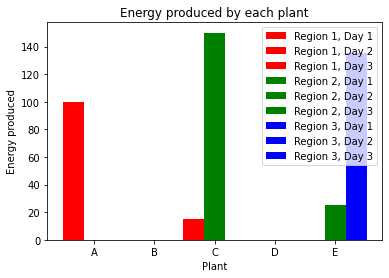

In [10]:
#Production of each plant in each region and day
fig, ax = plt.subplots()
width = 0.35
ind = numpy.arange(len(model.plants))
colors = ['r', 'g', 'b', 'y', 'm']
bars = []
for j in model.regions:
    for t in model.days:
        bars.append(ax.bar(ind + (j-1)*width, [model.x[i, j, t].value for i in model.plants], width, color=colors[j-1], label=f'Region {j}, Day {t}')
)
ax.set_xticks(ind + width)
ax.set_xticklabels(model.plants)
ax.set_xlabel('Plant')
ax.set_ylabel('Energy produced')
ax.set_title('Energy produced by each plant')
ax.legend()
plt.show()

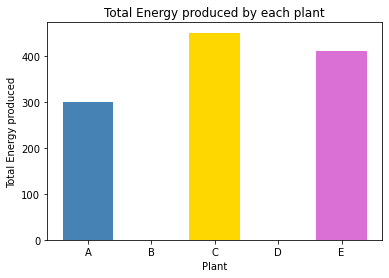

In [12]:
import numpy as np

#Total Production by Plant
fig, ax = plt.subplots()
ind = np.arange(len(model.plants))
colors = ['steelblue', 'seagreen', 'gold', 'coral', 'orchid']
ax.bar(ind, [sum(model.x[i, j, t].value for j in model.regions for t in model.days) for i in model.plants], color=colors[:len(model.plants)])
ax.set_xticks(ind)
ax.set_xticklabels(model.plants)
ax.set_xlabel('Plant')
ax.set_ylabel('Total Energy produced')
ax.set_title('Total Energy produced by each plant')
plt.show()

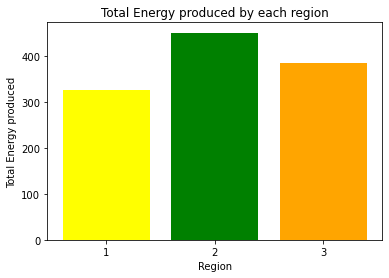

In [ ]:
import numpy as np

#Total Production by Region
fig, ax = plt.subplots()
ind = np.arange(len(model.regions))
colors = ['yellow', 'green', 'orange']
ax.bar(ind, [sum(model.x[i, j, t].value for i in model.plants for t in model.days) for j in model.regions], color=colors[:len(model.regions)])
ax.set_xticks(ind)
ax.set_xticklabels(model.regions)
ax.set_xlabel('Region')
ax.set_ylabel('Total Energy produced')
ax.set_title('Total Energy produced by each region')
plt.show()

The results show that Plants A and C, being cost-efficient and low-emission, are prioritized to meet the bulk of the demand across all regions, while Plant E is utilized specifically for Region 3 due to its capacity and emission constraints. Plant B remains unused because of its higher costs and the mutual exclusion rule with Plant A, and Plant D is not operational due to its high emissions and cost.